In [300]:
import itertools
import numpy as np
print(f'numpy version: {np.__version__}')
from pathlib import Path
from uncertainties import ufloat
from astropy.io import ascii
import pandas as pd
from astropy.table import Table
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib as mpl
from species import SpeciesInit
from species.data.database import Database
from species.read.read_model import ReadModel
from species.plot.plot_spectrum import plot_spectrum
import astropy.units as u
from astropy.io import fits, ascii

import urllib
from species import SpeciesInit
from species.data.database import Database
from species.fit.compare_spectra import CompareSpectra
from species.read.read_model import ReadModel
from species.plot.plot_comparison import plot_grid_statistic, plot_model_spectra
from species.plot.plot_spectrum import plot_spectrum
from species.util.box_util import update_objectbox
from species.util.fit_util import get_residuals
from species.phot.syn_phot import SyntheticPhotometry
# Set target

spec_file = f'./input/spectrum.fits'
spectrum = Table(fits.getdata(spec_file))   # flux in W m-2 um-2
display(spectrum)


numpy version: 1.24.3


WAVELENGTH,FLUX,COVARIANCE,CONTRAST,COVARIANCE_CONTRAST
float64,float64,float64[233],float64,float64[233]
1.9700000286102295,1.718685067351534e-16,1.9484786223401413e-33 .. 4.0221453531065934e-36,0.0007728486571293201,3.921080451503715e-08 .. -8.048846725104785e-11
1.9721983671188354,1.4089921411517234e-16,6.852990484573557e-35 .. 3.615809182479277e-36,0.0006535989157681976,1.2674094571333896e-09 .. -8.18714952618767e-11
1.9743965864181519,1.2533557849524717e-16,6.671393976864422e-35 .. 3.503821581228739e-36,0.0005953242530946998,1.2705674561159345e-09 .. -6.038050332381896e-11
1.9765948057174683,9.863676391540741e-17,6.08922121701629e-35 .. 1.4900786172500139e-36,0.0004984755184902698,1.2394233269310896e-09 .. -9.547631312963002e-11
1.9787930250167847,1.4060213234633553e-16,6.026702657328904e-35 .. 2.515247346851541e-36,0.0007398549782708634,1.2010573170468263e-09 .. -1.0218809103875521e-10
1.9809913635253906,1.4077030832949073e-16,6.089489998482279e-35 .. 2.6160634493269732e-36,0.0006854020459102524,1.1442505695598075e-09 .. -9.889162701785543e-11
1.983189582824707,1.345765235114303e-16,5.835043503237192e-35 .. 2.803525200426341e-36,0.0006401706136820693,1.0786370841547919e-09 .. -7.642151290165014e-11
1.9853878021240234,1.4482320319760133e-16,5.32035211244626e-35 .. 2.6787305112352336e-36,0.0007335911728084893,1.003498897135029e-09 .. -1.1074591877970416e-10
1.987586259841919,1.3123227619086782e-16,4.930911606447484e-35 .. 2.9834192315033194e-36,0.0006653310454656022,9.37401349783386e-10 .. -6.572936687315546e-11


In [301]:
# species test below
SpeciesInit()
database = Database()
parallax = ufloat(7.464925176349439, 0.021432146)


species v0.9.0

 -> A new version (0.10.0) is available!
 -> It is recommended to update to the latest version
 -> See https://github.com/tomasstolker/species for details

Working folder: /Users/rvc/github/wispit_2c

Configuration file: /Users/rvc/github/wispit_2c/species_config.ini
Database file: /Users/rvc/github/wispit_2c/species_database.hdf5
Data folder: /Users/rvc/github/wispit_2c/data

Configuration settings:
   - Database: /Users/rvc/github/wispit_2c/species_database.hdf5
   - Data folder: /Users/rvc/github/wispit_2c/data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed


In [302]:
# star magnitude
app_star = ufloat(8.591, 0.078)
contrast_2c = ufloat(7.39, 0.21)
app_2c = app_star + contrast_2c


# add sphere data point
#synphot = SyntheticPhotometry('Paranal/SPHERE.IRDIS_B_H')
synphot = SyntheticPhotometry('2MASS/2MASS.H')
flux, error = synphot.magnitude_to_flux(app_2c.n, error=app_2c.s)
print(f'Flux (W m-2 um-1) = {flux:.2e} +/- {error:.2e}')



Flux (W m-2 um-1) = 4.63e-16 +/- 9.61e-17


In [303]:
database.add_object(object_name='WISPIT 2 c',
                    app_mag={'2MASS/2MASS.H':(app_2c.n, app_2c.s)},
                    parallax=(parallax.n, parallax.s),
                    spectrum={'GRAVITY': (spec_file,
                                          spec_file,
                                          500.)})


----------
Add object
----------

Object name: WISPIT 2 c
Units: None
Deredden: None
Parallax (mas) = 7.46 +/- 0.02

Magnitudes:
   - 2MASS/2MASS.H:
      - Mean wavelength (um) = 1.6514e+00
      - Apparent magnitude = 15.98 +/- 0.22
      - Flux (W m-2 um-1) = 4.63e-16 +/- 9.61e-17

Spectra:
   - GRAVITY spectrum:
      - Object: Unknown
      - Database tag: GRAVITY
      - Filename: ./input/spectrum.fits
      - Data shape: (233, 3)
      - Wavelength range (um): 1.97 - 2.48
      - Mean flux (W m-2 um-1): 1.48e-16
      - Mean error (W m-2 um-1): 1.00e-17
   - GRAVITY covariance matrix:
      - Object: Unknown
      - Database tag: GRAVITY
      - Filename: ./input/spectrum.fits
      - Data shape: (233, 233)
   - Instrument resolution:
      - GRAVITY: 500.0


In [315]:
database.available_models()
modelname = 'atmo-petrus2023'


-----------------------
Available model spectra
-----------------------

   - AMES-Cond:
      - Label = ames-cond
      - Model parameters: ['teff', 'logg']
      - Teff range (K): [100, 6600]
      - Wavelength range (um): [0.5, 40]
      - Sampling (lambda/d_lambda): 4000
      - File size: 150 MB

   - AMES-Dusty:
      - Label = ames-dusty
      - Model parameters: ['teff', 'logg']
      - Teff range (K): [500, 4000]
      - Wavelength range (um): [0.5, 40]
      - Sampling (lambda/d_lambda): 4000
      - File size: 58 MB

   - ATMO:
      - Label = atmo
      - Model parameters: ['teff', 'logg']
      - Teff range (K): [200, 3000]
      - Wavelength range (um): [0.4, 6000]
      - Sampling (lambda/d_lambda): 1000
      - File size: 45 MB
      - Reference: Phillips et al. (2020)
      - URL: https://ui.adsabs.harvard.edu/abs/2020A%26A...637A..38P

   - ATMO CEQ:
      - Label = atmo-ceq
      - Model parameters: ['teff', 'logg']
      - Teff range (K): [200, 3000]
      - Wavele

In [305]:
database.add_model(modelname, teff_range=(1500., 2500.))



-------------------------
Add grid of model spectra
-------------------------

Database tag: atmo-petrus2023
Model name: ATMO (Petrus et al. 2023)

Unpacking 3465/7245 model spectra from ATMO (Petrus et al. 2023) (2.1 GB)... [DONE]

Please cite Petrus et al. (2023) when using ATMO (Petrus et al. 2023) in a publication
Reference URL: https://ui.adsabs.harvard.edu/abs/2023A%26A...670L...9P

Wavelength range (um) = 0.2 - 30
Sampling (lambda/d_lambda) = 3000
Teff range (K) = 1500.0 - 2500.0

Adding ATMO (Petrus et al. 2023) model spectra... data/atmo-petrus2023/atmo-petrus2023_teff_2400_logg_2.5_feh_0.6_co_0.30_adindex_1.01_spec.npy 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
compare = CompareSpectra(object_name='WISPIT 2 c',
                         spec_name=['GRAVITY'])

In [323]:
fix_logg = 4.

In [324]:
compare.compare_model(tag='WISPIT2c',
                      model=modelname,
                      av_points=None,
                      fix_logg=fix_logg,
                      scale_spec=None,
                      weights=False,
                      inc_phot=True)

Available photometric data for WISPIT 2 c:
   - 2MASS/2MASS.H
Processing model spectrum 495/495... [DONE]
Best-fit parameters:
   - Goodness-of-fit = 3.12e+02
   - teff = 2300.0
   - logg = 4.0
   - feh = 0.0
   - c_o_ratio = 0.7
   - ad_index = 1.05
   - Radius (Rjup) = 1.04
   - Scaling = 3.25e-22


In [325]:
#fig = plot_grid_statistic(tag='WISPIT2c',
#                          upsample=False,
#                          offset=None,
#                          output=None,
#                          extra_param='radius',
#                          nlevels_main=10,
#                          nlevels_extra=5)

Plotting model spectra comparison...

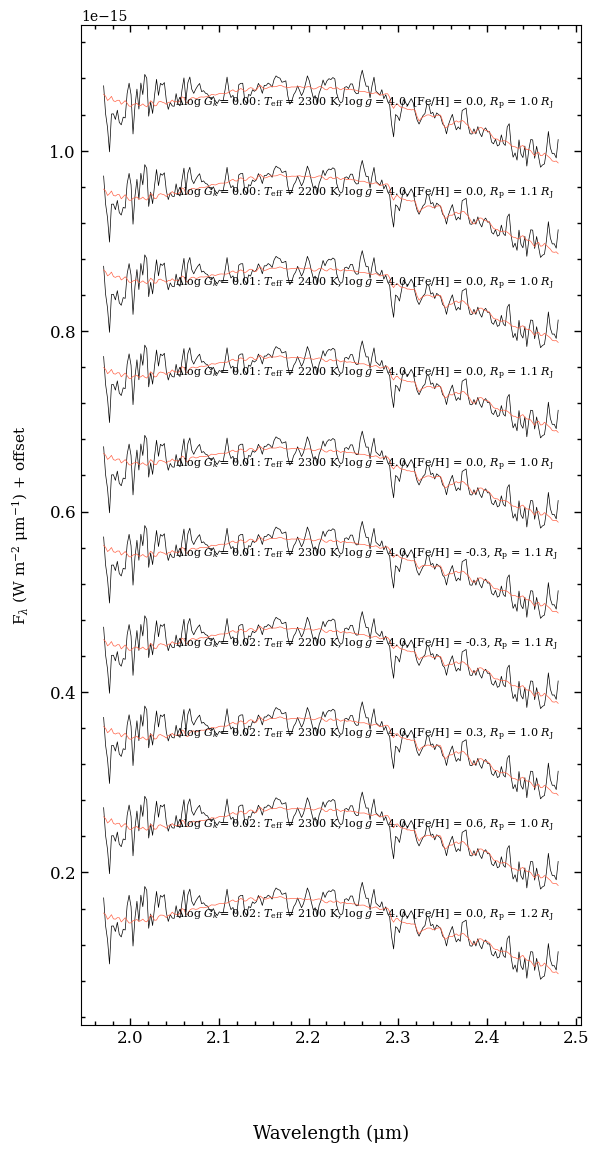

 [DONE]


In [326]:
fig = plot_model_spectra(tag='WISPIT2c',
                         n_spectra=10,
                         flux_offset=1e-16,
                         label_pos=(2.05, 1.5e-16),
                         xlim=None,
                         ylim=None,
                         title=None,
                         offset=None,
                         figsize=(5., 10.),
                         output=None,
                         leg_param=['teff', 'logg', 'feh', 'radius'])
fig.savefig(f'./output/spectra/{modelname}_logg_{str(fix_logg)}_comparison.png')


In [327]:
best = database.get_compare_sample('WISPIT2c')



------------------------------
Get best comparison parameters
------------------------------

Database tag: WISPIT2c

Parameters:
   - teff = 2300.00
   - logg = 4.00
   - feh = 0.00
   - c_o_ratio = 0.70
   - ad_index = 1.05
   - parallax = 7.46
   - radius = 1.04


In [328]:
object_box = database.get_object(object_name='WISPIT 2 c',
                                 inc_phot=True,
                                 inc_spec=True)


----------
Get object
----------

Object name: WISPIT 2 c
Include photometry: True
Include spectra: True


In [329]:
read_model = ReadModel(modelname)
model_box = read_model.get_model(best, spec_res=500.)

In [330]:
residuals = get_residuals(datatype='model',
                          spectrum=modelname,
                          tag='WISPIT2c',
                          parameters=best,
                          objectbox=object_box,
                          inc_phot=True,
                          inc_spec=True)


-------------------
Calculate residuals
-------------------

Selected results: CompareSpectra
Model: atmo-petrus2023

Model parameters:
   - teff
   - logg
   - feh
   - c_o_ratio
   - ad_index

Fixed parameters: none

Include photometry: True
Include spectra: True

Residuals (sigma):
   - 2MASS/2MASS.H = 1.84
   - GRAVITY: min = -4.37, max = 2.77

Number of data points = 234
Number of model parameters = 5
Number of fixed parameters = 0
Number of degrees of freedom = 229

chi2 = 311.60
reduced chi2 = 1.36



-------------
Plot spectrum
-------------

Boxes:
   - ModelBox
   - ObjectBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: None

Figure size: (6.0, 3.0)
Legend parameters: None
Include model name: False
Font sizes: {'xlabel': 11.0, 'ylabel': 11.0, 'title': 13.0, 'legend': 9.0}


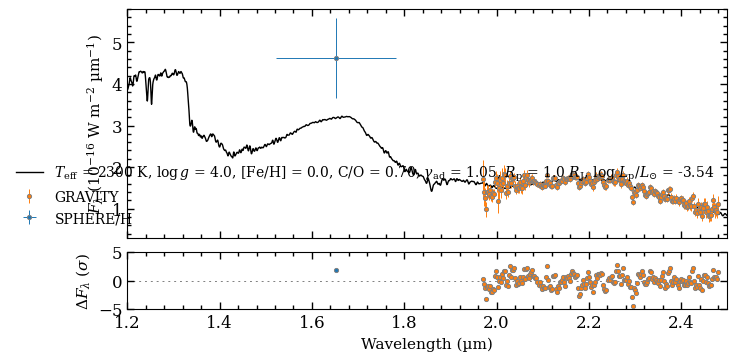


-------------
Plot spectrum
-------------

Boxes:
   - ModelBox
   - ObjectBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: None

Figure size: (6.0, 3.0)
Legend parameters: None
Include model name: False
Font sizes: {'xlabel': 11.0, 'ylabel': 11.0, 'title': 13.0, 'legend': 9.0}


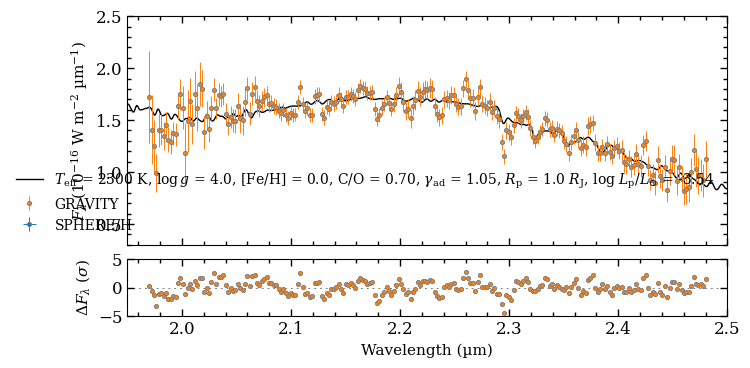

In [336]:
fig = plot_spectrum(boxes=[model_box, object_box],
                    filters=None,
                    residuals=residuals,
                    plot_kwargs=[{'ls': '-', 'lw': 1., 'color': 'black'},
                                 {'2MASS/2MASS.H': {'marker': 'o', 'ms': 3., 'elinewidth': 0.7, 'mew': 0.7, 'mec': 'gray', 'color': 'tab:blue', 'ls': 'none', 'label': 'SPHERE/H'},
                                 'GRAVITY': {'marker': 'o', 'ms': 3., 'elinewidth': 0.7, 'mew': 0.7, 'mec': 'gray', 'color': 'tab:orange', 'ls': 'none', 'label': 'GRAVITY'}}],
                    xlim=(1.2, 2.5),
                    #xlim=(2.0, 2.5),
                    #ylim=(0.3e-16, 9.8e-16),
                    ylim=(0.3e-16, 5.8e-16),
                    scale=('linear', 'linear'),
                    quantity='flux density',
                    legend={'loc': 'lower right', 'frameon': False, 'fontsize': 10.},
                    output=None)
fig.savefig(f'./output/spectra/{modelname}_logg_{str(fix_logg)}_bestfit.png')

fig = plot_spectrum(boxes=[model_box, object_box],
                    filters=None,
                    residuals=residuals,
                    plot_kwargs=[{'ls': '-', 'lw': 1., 'color': 'black'},
                                 {'2MASS/2MASS.H': {'marker': 'o', 'ms': 3., 'elinewidth': 0.7, 'mew': 0.7, 'mec': 'gray', 'color': 'tab:blue', 'ls': 'none', 'label': 'SPHERE/H'},
                                  'GRAVITY': {'marker': 'o', 'ms': 3., 'elinewidth': 0.7, 'mew': 0.7, 'mec': 'gray', 'color': 'tab:orange', 'ls': 'none', 'label': 'GRAVITY'}}],
                    #xlim=(1.2, 2.5),
                    xlim=(1.95, 2.5),
                    #ylim=(0.3e-16, 9.8e-16),
                    ylim=(0.3e-16, 2.5e-16),
                    scale=('linear', 'linear'),
                    quantity='flux density',
                    legend={'loc': 'lower right', 'frameon': False, 'fontsize': 10.},
                    output=None)
fig.savefig(f'./output/spectra/{modelname}_logg_{str(fix_logg)}_bestfit_zoom.png')


